In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer, StandardScaler

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv('../data/complete_clean.csv')

In [3]:
#Check DataFrame shape
df.shape

(1996, 7)

In [4]:
#Check for nulls
df.isnull().sum()

title                   0
selftext                0
subreddit               0
full_text               0
senti_score_comp        0
full_text_len           0
full_text_word_count    0
dtype: int64

In [5]:
#Changing subreddit column to 1s and 0s for prediction.
df['subreddit'] = df['subreddit'].map({'AskEngineers': 0, 'explainlikeimfive':1})

In [6]:
df.head()

,title,selftext,subreddit,full_text,senti_score_comp,full_text_len,full_text_word_count
0,ELI5 How do hand-cranked mobile shelving units...,I work in an office where these gigantic shelv...,1,how do hand cranked mobile shelving units work...,0.8627,445,80
1,ELI5 What made whale oil desirable as opposed ...,Wasn't sure whether to tag this as biology or ...,1,what made whale oil desirable as opposed to oi...,0.8316,273,51
2,ELI5 how is a transistor such a fast switch,Our CPUs have billions of transistors and each...,1,how is a transistor such a fast switch our cpu...,-0.4957,367,68
3,ELI5 What is CRISPR exactly and how far could ...,,1,what is crispr exactly and how far could it go...,0.0000,140,27
4,ELI5: Why can't we customize our phone/mobile ...,"Like the title says, I love tech but know next...",1,why can t we customize our phone mobile hardwa...,0.9423,404,76


## Pre-Processing

In [7]:
#Create a function that splits and lemmatizes text
def lemmatize_text(text):
    #Instantiate Lemmatizer
    lemmatizer = WordNetLemmatizer()
    split_text = text.split(' ')
    return [lemmatizer.lemmatize(word.lower()) for word in split_text]

In [8]:
#Create a function that splits and stemmes text
def stem_text(text):
    #Instantiate Stemmer
    stemmer = PorterStemmer()
    split_text = text.split(' ')
    return [stemmer.stem(word.lower()) for word in split_text]

These are pre-processing options which will later be used in the GridSearchCV to check which one gives a better score. 

## Baseline Model Accuracy

In [9]:
df['subreddit'].value_counts(normalize=True)

0    0.5
1    0.5
Name: subreddit, dtype: float64

Baseline model's accuracy is 50%. 

## Features & Train/Test Split

In [10]:
X = df.drop(columns=['title','selftext','subreddit'])
X.head()

,full_text,senti_score_comp,full_text_len,full_text_word_count
0,how do hand cranked mobile shelving units work...,0.8627,445,80
1,what made whale oil desirable as opposed to oi...,0.8316,273,51
2,how is a transistor such a fast switch our cpu...,-0.4957,367,68
3,what is crispr exactly and how far could it go...,0.0000,140,27
4,why can t we customize our phone mobile hardwa...,0.9423,404,76


In [11]:
y = df['subreddit']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Checking the shape of train and test datasets.

In [13]:
X_train.shape

(1497, 4)

In [14]:
X_test.shape

(499, 4)

As the data is equally split between the two classes, the train/test split need not be stratified. 

## Most Common Words

In [15]:
#Instantiate CountVectorizer
cvect = CountVectorizer(binary=True,min_df=7,max_df=0.98, tokenizer=lemmatize_text)

In [16]:
X_train_cvect = cvect.fit_transform(X_train['full_text'])

In [17]:
cvect_df = pd.DataFrame(X_train_cvect.todense(),columns=cvect.get_feature_names())

In [18]:
cvect_df.head()

,0,000,1,10,100,11,12,15,18,2,...,x200b,y,year,yes,yet,you,young,your,youtube,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [19]:
cvect_df.shape

(1497, 1593)

In [20]:
cvect_df.insert(0,'subreddit',y_train)

In [21]:
cvect_df

,subreddit,0,000,1,10,100,11,12,15,18,...,x200b,y,year,yes,yet,you,young,your,youtube,zero
0,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1493,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1494,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1495,0.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [22]:
y_train

1454    0
1763    0
182     1
1962    0
715     1
       ..
1130    0
1294    0
860     1
1459    0
1126    0
Name: subreddit, Length: 1497, dtype: int64

# Model

## Build Pipelines

In [23]:
#Create a function to extract full_text column from the dataframe 
def get_text_col(df):
    return df['full_text']

#Convert the function into a trasformer using FunctionTransformer
get_text_col_tf = FunctionTransformer(get_text_col, validate=False)

In [24]:
#Create a function to extract numerical columns from the dataframe 
def get_num_cols(df):
    return df[['senti_score_comp','full_text_len','full_text_word_count']]

#convert the function into a transformer using FunctionTransformer
get_num_cols_tf = FunctionTransformer(get_num_cols, validate=False)

In [25]:
#Create a pipeline for the textual column of X_train
cvect_pipe = Pipeline([
    #function
    ('get_text_col_tf',get_text_col_tf),
    #CountVectorizer
    ('vect', CountVectorizer()),
])

In [26]:
#Create a pipeline for numerical columns of X_train
ss_pipe = Pipeline([
    #function turned transformer
    ('get_num_cols_tf', get_num_cols_tf),
    #Standard Scaler transformer
    ('ss', StandardScaler())
])

## Feature Union

In [27]:
#Create a feature union to bring back the trandformed DataFrame together
feat = FeatureUnion([
    ('cvect_pipe', cvect_pipe), 
    ('ss_pipe',ss_pipe)
])

Feature Union clubs together different pipelines. Essentially, it is putting back a transformed DataFrame. 

## Model1 - Logistic Regression

In [28]:
#Create a pipeline for the main model 
model1_pipe = Pipeline([
    ('feat', feat), 
    ('lr', LogisticRegression())
])

## GridSearchCV

In [29]:
#Display parameters of model1 pipeline
[keys for keys in model1_pipe.get_params().keys()]

['memory',
 'steps',
 'verbose',
 'feat',
 'lr',
 'feat__n_jobs',
 'feat__transformer_list',
 'feat__transformer_weights',
 'feat__verbose',
 'feat__cvect_pipe',
 'feat__ss_pipe',
 'feat__cvect_pipe__memory',
 'feat__cvect_pipe__steps',
 'feat__cvect_pipe__verbose',
 'feat__cvect_pipe__get_text_col_tf',
 'feat__cvect_pipe__vect',
 'feat__cvect_pipe__get_text_col_tf__accept_sparse',
 'feat__cvect_pipe__get_text_col_tf__check_inverse',
 'feat__cvect_pipe__get_text_col_tf__func',
 'feat__cvect_pipe__get_text_col_tf__inv_kw_args',
 'feat__cvect_pipe__get_text_col_tf__inverse_func',
 'feat__cvect_pipe__get_text_col_tf__kw_args',
 'feat__cvect_pipe__get_text_col_tf__validate',
 'feat__cvect_pipe__vect__analyzer',
 'feat__cvect_pipe__vect__binary',
 'feat__cvect_pipe__vect__decode_error',
 'feat__cvect_pipe__vect__dtype',
 'feat__cvect_pipe__vect__encoding',
 'feat__cvect_pipe__vect__input',
 'feat__cvect_pipe__vect__lowercase',
 'feat__cvect_pipe__vect__max_df',
 'feat__cvect_pipe__vect__max

In [30]:
#Define paramaters for model1 pipeline
model1_params = {
    'feat__cvect_pipe__vect__stop_words': [None],
    'feat__cvect_pipe__vect__tokenizer': [lemmatize_text, stem_text,None],
    'feat__cvect_pipe__vect__max_features': [1000,1200],
    'feat__cvect_pipe__vect__min_df': range(1,10,2),
    'feat__cvect_pipe__vect__max_df': [0.98, 0.85],
    'feat__cvect_pipe__vect__binary': [True,False],
    'lr__max_iter': [200,250,300]
}

model1_gs = GridSearchCV(model1_pipe, param_grid=model1_params)
model1_gs.fit(X_train,y_train)
print(model1_gs.best_score_)
model1_gs.best_params_

0.945886287625418


{'feat__cvect_pipe__vect__binary': True,
 'feat__cvect_pipe__vect__max_df': 0.98,
 'feat__cvect_pipe__vect__max_features': 1200,
 'feat__cvect_pipe__vect__min_df': 7,
 'feat__cvect_pipe__vect__stop_words': None,
 'feat__cvect_pipe__vect__tokenizer': <function __main__.lemmatize_text(text)>,
 'lr__max_iter': 200}

For this model, there was conflict between using lemmatizer or stop_words. The option forward, based on best_score_, was using a lemmatizer. Hence there is no **'stop_words': 'english'** in the hyperparamaters. 

## Model Evaluation

**Scores**

In [126]:
cross_val_score(model1_gs, X_train, y_train).mean()

KeyboardInterrupt: 

In [51]:
model1_gs.score(X_train, y_train)

0.9953239812959251

In [52]:
model1_gs.score(X_test, y_test)

0.9298597194388778

The train score is exceptionally high as compared to test score. The model may have overfit to the train dataset. 

Plotting a confusion matrix in the cell below. 

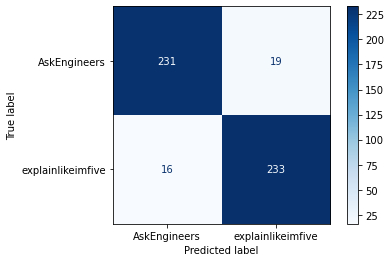

In [32]:
plot_confusion_matrix(model1_gs, X_test, y_test, display_labels=['AskEngineers','explainlikeimfive'], 
                     values_format='d',cmap='Blues')
plt.savefig('../images/confusion_matrix.png');

## Predictions

In [33]:
model1_pred = model1_gs.predict(X_test)

In [34]:
model1_pred

array([1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,

In [35]:
model1_probs = model1_gs.predict_proba(X_test)[:,1]

In [36]:
model1_probs

array([9.94518647e-01, 2.06980838e-04, 1.52266397e-01, 1.19439117e-02,
       9.92027180e-01, 7.29475794e-01, 8.95194558e-01, 6.07223679e-05,
       8.13866325e-02, 1.36731276e-04, 9.73370094e-01, 9.98828217e-01,
       1.15170471e-01, 8.86472947e-01, 8.14091145e-03, 5.86057080e-03,
       9.96607648e-01, 7.86171123e-02, 9.86844341e-01, 9.38119160e-01,
       9.91583105e-01, 1.87451780e-01, 5.52924277e-01, 1.45030204e-02,
       9.99791954e-01, 1.03099131e-01, 9.94619593e-01, 9.98853612e-01,
       5.11174763e-03, 9.07493716e-03, 9.82566610e-01, 8.43171941e-03,
       8.38294844e-01, 9.89563934e-01, 1.25966932e-01, 1.96549657e-03,
       9.75967613e-01, 9.94066933e-01, 7.52739200e-03, 9.60844372e-01,
       9.04496487e-01, 9.95824255e-01, 1.01186007e-01, 8.59523026e-03,
       9.40033832e-01, 4.58986858e-04, 8.67221981e-01, 9.77635935e-01,
       9.71810910e-01, 9.69750425e-01, 9.83076091e-01, 9.56837737e-01,
       1.49079315e-03, 4.39095051e-01, 9.81796104e-01, 4.76735904e-03,
      

In [37]:
model1_pred_df = pd.DataFrame({'true_values': y_test,
                       'pred_probs': model1_probs})
model1_pred_df.head()

,true_values,pred_probs
889,1,0.994519
1674,0,0.000207
414,1,0.152266
1427,0,0.011944
849,1,0.992027


/Users/ankitapatil/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


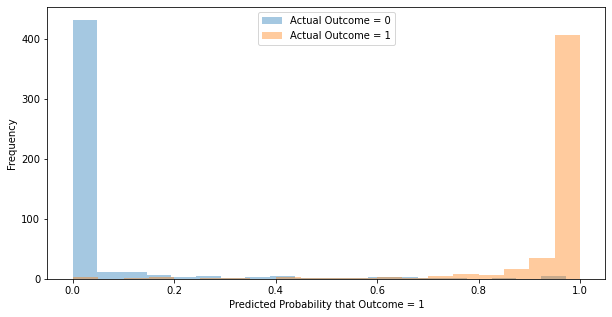

In [50]:
plt.figure(figsize = (10, 5))

# plot distributions of predicted probabilities by actual values
for group in model1_pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.ylabel('Frequency')
plt.legend(loc='upper center')
plt.savefig('../images/probability_comparison');

In [39]:
print(f"Precision Score: {precision_score(y_test, model1_pred)}"),
print(f"Recall Score: {recall_score(y_test, model1_pred)}"),
print(f"Accuracy Score: {accuracy_score(y_test, model1_pred)}")

Precision Score: 0.9246031746031746
Recall Score: 0.9357429718875502
Accuracy Score: 0.9298597194388778


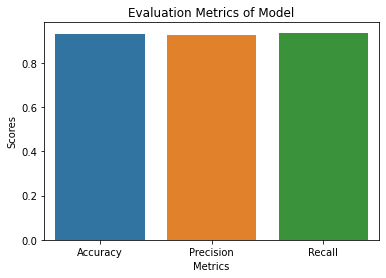

In [41]:
scores = ['Accuracy', 'Precision', 'Recall']
score_values = [accuracy_score(y_test, model1_pred), precision_score(y_test, model1_pred),recall_score(y_test, model1_pred)]
sns.barplot(x=scores, y = score_values)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Evaluation Metrics of Model')
plt.savefig('../images/metrics');

## Top Predictors

In [42]:
#Match the coefficients from Logistic Regression to features from Count Vectorizer
model1_coefs = model1_gs.best_estimator_.named_steps.lr.coef_
model1_predictors = model1_gs.best_estimator_.named_steps['feat'].transformer_list[0][1].named_steps['vect'].get_feature_names()

In [43]:
#Zip them together and turn them into a list
model1_coef_predictor = list(zip(model1_coefs[0],model1_predictors))

In [44]:
model1_df_coef = pd.DataFrame(model1_coef_predictor, columns=['coefficients', 'predictors'])

In [45]:
model1_df_coef

,coefficients,predictors
0,0.023036,0
1,0.096919,1
2,-0.335634,10
3,0.387293,100
4,-0.513449,11
...,...,...
1195,-0.139898,yet
1196,-0.386663,you
1197,-0.903984,your
1198,-0.063869,youtube


The model is predicting how likely each post will be in category 1, i.e. subreddit - **explainlikeimfive** as compared to category 0, i.e. subreddit - **AskEngineers**

In [46]:
#Top 10 predictors of subreddit - explainlikeimfive
model1_top_eli5_pred = model1_df_coef.sort_values(by='coefficients', ascending=False)
model1_top_eli5_pred.head(15)

,coefficients,predictors
332,6.017847,engineering
1161,1.508657,why
441,0.932305,genetic
364,0.916949,explain
522,0.880666,how
366,0.836585,explanation
284,0.774319,difference
1143,0.767001,we
1105,0.745623,understand
955,0.744013,so


In [47]:
#Top 10 predictors of subreddit - AskEngineers
model1_top_aske_pred = model1_df_coef.sort_values(by='coefficients', ascending=False)
model1_top_aske_pred.tail(15)

,coefficients,predictors
1134,-0.736259,want
1054,-0.744612,there
765,-0.768025,own
568,-0.777316,job
452,-0.797691,good
503,-0.799724,hi
170,-0.805591,career
907,-0.817262,school
339,-0.894670,environmental
1197,-0.903984,your


In [48]:
#Put together the predictors in one DataFrame
top_predictors = pd.concat([model1_top_eli5_pred.head(15),model1_top_aske_pred.tail(15)])

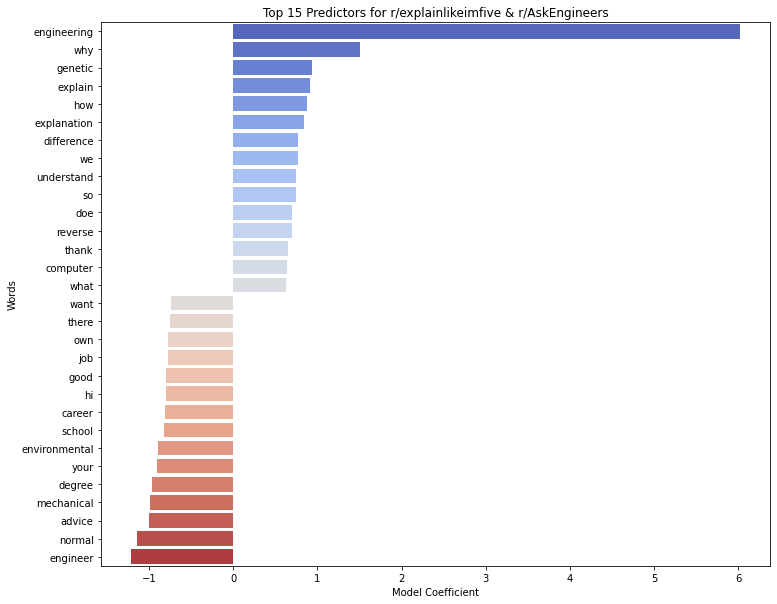

In [49]:
plt.figure(figsize=(12,10))
sns.barplot(y = top_predictors['predictors'],x=top_predictors['coefficients'], palette='coolwarm')
plt.xlabel('Model Coefficient')
plt.ylabel('Words')
plt.title('Top 15 Predictors for r/explainlikeimfive & r/AskEngineers')
plt.savefig('../images/top_predictors');

## Model 2 - Random Forests Classifier

In [53]:
model2_pipe = Pipeline([
    ('feat', feat), 
    ('rf', RandomForestClassifier(random_state=42))
])

## GridSearchCV

In [56]:
#Display parameters of model1 pipeline
[keys for keys in model2_pipe.get_params().keys()]

['memory',
 'steps',
 'verbose',
 'feat',
 'rf',
 'feat__n_jobs',
 'feat__transformer_list',
 'feat__transformer_weights',
 'feat__verbose',
 'feat__cvect_pipe',
 'feat__ss_pipe',
 'feat__cvect_pipe__memory',
 'feat__cvect_pipe__steps',
 'feat__cvect_pipe__verbose',
 'feat__cvect_pipe__get_text_col_tf',
 'feat__cvect_pipe__vect',
 'feat__cvect_pipe__get_text_col_tf__accept_sparse',
 'feat__cvect_pipe__get_text_col_tf__check_inverse',
 'feat__cvect_pipe__get_text_col_tf__func',
 'feat__cvect_pipe__get_text_col_tf__inv_kw_args',
 'feat__cvect_pipe__get_text_col_tf__inverse_func',
 'feat__cvect_pipe__get_text_col_tf__kw_args',
 'feat__cvect_pipe__get_text_col_tf__validate',
 'feat__cvect_pipe__vect__analyzer',
 'feat__cvect_pipe__vect__binary',
 'feat__cvect_pipe__vect__decode_error',
 'feat__cvect_pipe__vect__dtype',
 'feat__cvect_pipe__vect__encoding',
 'feat__cvect_pipe__vect__input',
 'feat__cvect_pipe__vect__lowercase',
 'feat__cvect_pipe__vect__max_df',
 'feat__cvect_pipe__vect__max

In [57]:
model2_params = {
    'feat__cvect_pipe__vect__stop_words': [None],
    'feat__cvect_pipe__vect__tokenizer': [lemmatize_text, stem_text,None],
    'feat__cvect_pipe__vect__min_df': range(1,10,2),
    'feat__cvect_pipe__vect__max_df': [0.98,0.85],
    'feat__cvect_pipe__vect__max_features': [1000,1200],
    'rf__n_estimators': [100,150,200],
    'rf__max_features': ['auto',3]    
}
model2_gs = GridSearchCV(model2_pipe, param_grid=model2_params)
model2_gs.fit(X_train, y_train)
print(model2_gs.best_score_)
model2_gs.best_params_

0.9271928651059087


{'feat__cvect_pipe__vect__max_df': 0.98,
 'feat__cvect_pipe__vect__max_features': 1000,
 'feat__cvect_pipe__vect__min_df': 5,
 'feat__cvect_pipe__vect__stop_words': None,
 'feat__cvect_pipe__vect__tokenizer': None,
 'rf__max_features': 'auto',
 'rf__n_estimators': 200}

The best_score_ for the model with Random Forest Classifier came lower than the one for Logistic Regression. Hence, Model 1 - Logistic Regression is being considered to prove the hypothesis. 

## Conclusions and Recommendations

Using data from Reddit's API, a classification model is built using Count Vectorizer and Logistic Regression, with an accuracy of 93%. Another model using the same data was built using Count Vectorizer and Random Forrest Classifier. This model was rejected over the previous model  due to a comparatively low best score compared to the former. The best score is an average of r2 scores on left-out test folds, when the train data is split into folds, for the best parameter combination.

The final model takes in both text and numerical columns, separates them using pipeline and transforms them separately. The text data is counter vectorized, meaning it converts a text into a vector on the basis of the frequency of each word. On the other hand, the numerical data is scaled using StandardScalar. This is to avoid some featuers becoming more dominant than the others based on their magnitude. The vectorized and scaled data is then brought back together using Feature Union. This is then fed into the final estimation model Logistic Regression, through a pipeline. Logistic Regression models the probability of a discrete outcome. The probabilty of the target variable determines its category. The rows/observations with predicted probability more than 0.5 are categorized 1 (target category) and the ones with predicted probabilty less than 0.5 are categorized as 0 (non-target category). The best predictors (words) are obtained by putting together the model coefficients of Logistic Regression Model and model features of Count Vectorizer. 

Based on the Confusion Matrix, the number of False Positives are 20 and number of False Negatives are 16. The False Positives are Type 1 Errors and False Negatives are Type 2 Errors. Based on the application, it can be determined what kind error needs to be minimized. A real world application for this model would be categorizing a blog post into novice and expert. This could be an addition alongside *reading time* feature. If a company is trying to attract readers who are not subject matter experts, the company would want to minimize Type 1 Errors as it wants to encourage more readers.

Amongst the top predictors for r/explainlikeimfive is engineering, which is obvious considering we used that as the search term. But some of the other top predictors are why, explain, how, explanation, difference, understand, reverse, computer and what. On the other hand, for r/AskScience, they are engineer, normal, advice, mechanical, degree, environmental, school, career, job, own, want. We can definitely see a pattern in these words. The words from r/explainlikeimfive are more towards trying to understand things with why, how and what. Whereas, words from r/AskScience are more specific to the field. 

It can be pointed out that based on the words used in the posts, you can predict the subject matter expertise in the field and the difficulty level of the post. 

As a future step, it would be worth to further explore Decision Trees along with ensemble methods. Ensemble methods use multiple algorithms and make predictions on the target variable with better results as compared to individual algorithms. Boosting, AdaBoosting and Stacking could be considered for the model in future. 